## Finding Pits with Graupel

**Goal**: Find all pits with graupel mentioned in the comments by the observers.

**Approach**: 

1. Use the `LayerData` class to represent the entire layers table
2. Form the query using Objet Relational Mapping (ORM)
3. Fill out all variables in the query using compile. 
4. Form a geodataframe using the engine and complete SQL command
5. Output to a file.



In [4]:
from snowxsql.data import LayerData
from snowxsql.db import get_db
import geopandas as gpd
from sqlalchemy.dialects import postgresql

# Connect to the database we made.
db_name = 'postgresql+psycopg2:///snowex'
engine, metadata, session = get_db(db_name)

# Query the database looking at LayerData, filter on comments containing graupel (case insensitive)
q = session.query(LayerData).filter(LayerData.comments.contains('graupel'))

# Fill out the variables in the query
sql = q.statement.compile(dialect=postgresql.dialect())

# Get dataframe from geopandas using the query and engine
df = gpd.GeoDataFrame.from_postgis(sql, engine)

# Close the geoalchemy2 session
session.close()

# Write data to a shapefile
df['geom'].to_file('graupel_locations.shp')


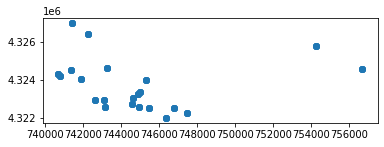

In [5]:
df.plot()